# Streaming Data and Kafka: Data Storage and Visualization

## Producing Events from Wikipedia
To simulate an application generating events for Kafka, this simple Python producer application is created that reads events from Wikipedia and sends them to the wiki-changes Kafka topic.

The message is serialized in JSON format to send to the Kafka topic. The library sseclient is required to read the source events and the kafka-python enables the Python to produce Kafka messages.

In practice, Producers (pushing records into Kafka topics within the broker) and Consumers (pulling records off a Kafka topic) are often activated simultaneously based on multiple brokers. We do not use ```localhost``` or ```127.0.0.1``` as the host ip if we need to run multiple brokers. Given limited flexibility of Google Colab Free Access, however, we simplify this exercise and rely on ```localhost```.

(Optional) Please read the following references if you desire to exercise further; e.g., establishing docker containers with compose.

References:

* [Spark application that consumes Kafka events generated by a Python producer.](https://github.com/cordon-thiago/spark-kafka-consumer/tree/master)
* [Enabling streaming data with Spark Structured Streaming and Kafka](https://medium.com/data-arena/enabling-streaming-data-with-spark-structured-streaming-and-kafka-93ce91e5b435)

## Install Libraries

In [ ]:
!pip install pyspark

### SSEClient
```sseclient``` is a Python client library for iterating over http Server Sent Event (SSE) streams (also known as EventSource, after the name of the Javascript interface inside browsers). The SSEClient class accepts a url on init, and is then an iterator over messages coming from the server.

In [ ]:
!pip install sseclient

  Preparing metadata (setup.py) ... done
  Created wheel for sseclient: filename=sseclient-0.0.27-py3-none-any.whl size=5562 sha256=89489daa366425adc5202c9399a425dcbf3708c96b344809ba7377c263e60036
  Stored in directory: /root/.cache/pip/wheels/60/57/0e/09b1264923280e935a34cc543b7f147f5df12490bd7a992f42
Successfully built sseclient


In [ ]:
!pip install kafka-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
# the code below mounts your google drive to /content/drive folder
# you might need to provide authorizations using your google account
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
from datetime import datetime
import time
import threading
import json
import kafka
from kafka import KafkaProducer
from kafka.errors import KafkaError
import requests
from sseclient import SSEClient as EventSource

In [ ]:
# Download Apache Kafka and unzip into your Google Colab session.
!curl -sSOL https://archive.apache.org/dist/kafka/3.1.0/kafka_2.13-3.1.0.tgz
!tar -xzf kafka_2.13-3.1.0.tgz

In [ ]:
# start zookeeper server & kafka server set $KAFKA_HOME variable path in bashrc (i.e., a configuration file for the Bash shell).
!./kafka_2.13-3.1.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.1.0/config/zookeeper.properties #--override delete.topic.enable=true
!./kafka_2.13-3.1.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.1.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
# see if kafka properties are shown in the results.
!ps -ef | grep kafka

root        3191       1  1 02:38 ?        00:00:03 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.1.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.1.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.1.0/bin/../config/log4j.properties -cp /content/kafka_2.13-3.1.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

## Event Producer

In [ ]:
import json
from sseclient import SSEClient as EventSource
from kafka import KafkaProducer

# Create producer
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8') #json serializer
    )

### Event Platform/EventStreams
[EventStreams](https://wikitech.wikimedia.org/wiki/Event_Platform/EventStreams) is a web service that exposes continuous streams of structured event data.

EventStreams provides access to several different data streams, most notably the ```recentchange``` stream which emits MediaWiki Recent changes events. For a complete list of available streams, refer to the documentation at [https://stream.wikimedia.org/?doc#/streams](https://stream.wikimedia.org/?doc#/streams).

The data format of each stream follows a schema. The schemas can be obtained via [https://schema.wikimedia.org/#!/primary/jsonschema](https://schema.wikimedia.org/#!/primary/jsonschema), for example, [here](https://schema.wikimedia.org/repositories/primary/jsonschema/mediawiki/recentchange/latest.yaml). For the ```recentchange``` stream there is additional documentation at [Manual:RCFeed on mediawiki.org](https://www.mediawiki.org/wiki/Manual:RCFeed).

Please also visit Wikepedia's [API:Main page](https://www.mediawiki.org/wiki/API:Main_page) and [API:Tutorial](https://www.mediawiki.org/wiki/API:Tutorial#:~:text=For%20example%2C%20the%20English%20Wikipedia,API%20which%20action%20to%20perform) for more details about Wikipedia's API.

**Click the ```streaming_url``` url in the below code or this link to explore how the streaming data looks like:** [https://stream.wikimedia.org/v2/stream/recentchange](https://stream.wikimedia.org/v2/stream/recentchange)


In [ ]:
# Read streaming event
streaming_duration = 30  # Modify this value for longer/shorter streaming duration.
start_time = time.time()

# Create a new csv file to store the streaming data.
f = open('/content/drive/MyDrive/Colab Notebooks/MIS584 FA2023/Assignment3/wikidata/wikidata.csv', 'w')
f.write('{},{},{},{},{},{}\n'.format(                         # write csv headers to the file
    'server_name', 'type', 'user', 'title','timestamp','comment'))
f.close()

streaming_url = 'https://stream.wikimedia.org/v2/stream/recentchange'

try:
    for event in EventSource(streaming_url):
      now_time = time.time()

      if now_time - start_time > streaming_duration:      # check if data streaming needs to end
        print(end='\n'*2)
        print("Streaming ended.", end='\n'*2)
        producer.flush()
        # # producer.close()
        break

      if event.event == 'message':
          try:
              change = json.loads(event.data)             # convert json line into dictionary
          except ValueError:
              pass
          else:
              #Send msg to topic wiki-changes
              topic = 'wiki-changes'
              producer.send(topic, change)

              ################
              # OPTIONAL: you may filter where recentchange event.server_name == server_name_filter, e.g.,
              # server_name_filter = 'en.wikipedia.org'
              # Adjust indentation to equip with the following "if" statement.
              # if change['server_name'] == server_name_filter:

              type_filter = 'edit'
              #store Wiki recent change stream data
              wiki_data = {
                    'server_name': change['server_name'],
                    'type': change['type'],
                    'user': change['user'],
                    'title': change['title'],
                    'bot': change['bot'],
                    'timestamp': change['timestamp'],
                    'namespace': change['namespace'],
                    'comment': change['comment'],
                    'bot': change['bot'],
                    'server_url': change['server_url'],
                    'server_script_path': change['server_script_path'],
                    'wiki': change['wiki'],
                    'parsedcomment': change['parsedcomment'],
                    'meta': {
                        'domain': change['meta']['domain'],
                        'dt': change['meta']['dt'],
                        'id': change['meta']['id'],},
                    'offset': change['meta']['offset'],
                    'partition': change['meta']['partition'],
                    'request_id': change['meta']['request_id'],
                    'stream': change['meta']['stream'],
              }
              #print user and title edited
              # print('{user} edited {title}'.format(**change))

              # print streamed wiki recentchange
              print(wiki_data)

              f = open('/content/drive/MyDrive/Colab Notebooks/MIS584 FA2023/Assignment3/wikidata.csv', 'a') # Change it to your path.
              f.write('{},{},{},{},{},"{}"\n'.format(               # append wiki recent change data to the csv file
              wiki_data['server_name'],
              wiki_data['type'],
              wiki_data['user'],
              wiki_data['title'],
              wiki_data['timestamp'],
              wiki_data['comment']
              ))

except KeyboardInterrupt:
    print("process interrupted")


{'server_name': 'commons.wikimedia.org', 'type': 'edit', 'user': 'SchlurcherBot', 'title': 'File:Sigtuna Strandpromenad, 2011.jpg', 'bot': True, 'timestamp': 1697168709, 'namespace': 6, 'comment': '/* wbeditentity-update:0| */ automatically modify [[Commons:Structured data|structured data]] based on file information: camera meta copyright license source', 'server_url': 'https://commons.wikimedia.org', 'server_script_path': '/w', 'wiki': 'commonswiki', 'parsedcomment': '\u200e<span dir="auto"><span class="autocomment">Ein Objekt geändert: </span></span> automatically modify <a href="/wiki/Commons:Structured_data" title="Commons:Structured data">structured data</a> based on file information: camera meta copyright license source', 'meta': {'domain': 'commons.wikimedia.org', 'dt': '2023-10-13T03:45:09Z', 'id': '4ec2ecef-285b-4e4a-85cf-3994ac40e198'}, 'offset': 683293194, 'partition': 0, 'request_id': '12f27495-d45b-4c3e-ad19-7797f2cd37ca', 'stream': 'mediawiki.recentchange'}
{'server_name'

In [ ]:
# Define consumer
bootstrap_server = "localhost:9092"
group_id = "my_wiki"
consumer = kafka.KafkaConsumer(
    bootstrap_servers=[bootstrap_server],
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),
    group_id = group_id
)

In [ ]:
# Subsribe to a specified topic: 'wiki-changes' in our case.
topic = 'wiki-changes'
consumer.subscribe(topics=[topic])
consumer.subscription()

{'wiki-changes'}

In [ ]:
import time
import json
import datetime
import kafka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [ ]:
# sc.stop()   # stop spark context

In [ ]:
import pandas as pd
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("MIS584_Spark_Examples")
sc = SparkContext(conf = conf)

In [ ]:
# Interrupt if no output being added.

try:
  change_userlist = []
  for message in consumer:

      print (message.value['user'])
      change_userlist.append(message.value['user'])

except KeyboardInterrupt:
    print("process interrupted")

ST47ProxyBot
2601:248:4600:14D0:7E17:BE4F:A486:1ED7
Cewbot
ST47ProxyBot
MidleadingBot
Bamyers99
วรุฒ หิ่มสาใจ
InternetArchiveBot
BoyTheKingCanDance
BoyTheKingCanDance
ST47ProxyBot
Cewbot
ST47ProxyBot
BoyTheKingCanDance
BoyTheKingCanDance
ST47ProxyBot
Kitrsjlhf
MidleadingBot
Prmmprmm
Prmmprmm
Prmmprmm
Prmmprmm
Bamyers99
Prmmprmm
KGRAMR
ST47ProxyBot
LucaDrBiondi
Hsuananwang
Cewbot
Anakabot
Archangel Zadkiel
Bamyers99
ST47ProxyBot
SchlurcherBot
Kitrsjlhf
ST47ProxyBot
X20230905123
Epicgenius
MidleadingBot
Bamyers99
HappyWithWhatYouHaveToBeHappyWith
ST47ProxyBot
BaseballFanatic1
The Green Star Collector
InternetArchiveBot
ST47ProxyBot
SchlurcherBot
ST47ProxyBot
KrBot
A1Cafel
A1Cafel
A1Cafel
A1Cafel
A1Cafel
Aleth Bot
A1Cafel
A1Cafel
A1Cafel
A1Cafel
LucaDrBiondi
A1Cafel
ST47ProxyBot
Dexbot
MarbleGarden
CzarJobKhaya
ST47ProxyBot
MidleadingBot
Bamyers99
Halowand
Orenb12
KrBot
Emijrpbot
ST47ProxyBot
Tomy 2710
CzarJobKhaya
A1Cafel
A1Cafel
A1Cafel
A1Cafel
A1Cafel
A1Cafel
KrBot
A1Cafel
A1Cafel
Bamy

In [ ]:
# Count occurrences for each user
users_count = sc.parallelize(change_userlist).map(lambda word: (word, 1)).reduceByKey(
    lambda count1, count2: count1 + count2
)

# Sort word occurrences in the descending order
users_count_sorted = users_count.sortBy(lambda x: -x[1])

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

                  user  count
0         ST47ProxyBot     92
1            Gzen92Bot     49
2          GeographBot     46
3              A1Cafel     39
4            Bamyers99     31
5        MidleadingBot     28
6                KrBot     21
7            Emijrpbot     16
8             Jobu0101     15
9       FlickreviewR 2     15
10        LucaDrBiondi     11
11       SSoster (WMB)     11
12                  리듬     10
13            DeltaBot     10
14       SchlurcherBot      9
15          TohaomgBot      9
16  InternetArchiveBot      8
17        MarbleGarden      8
18                YoaR      8
19       Mr.Ibrahembot      8
**********************
Graph - Top 20 users
**********************


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46316 (\N{HANGUL SYLLABLE DEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


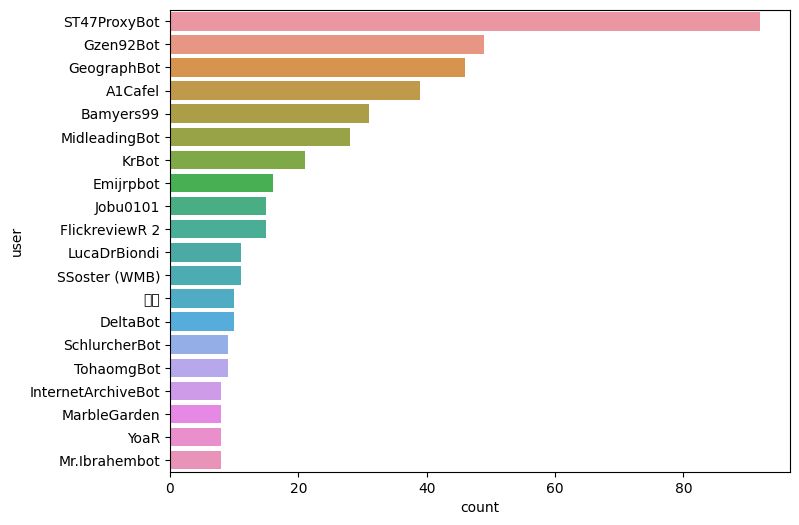

In [ ]:
# Plot top 20 users from the list
top20_users = users_count_sorted.take(20)
top20_pd = pd.DataFrame(top20_users, columns=['user', 'count'])
print(top20_pd)

sns.set_color_codes("muted")
# Initialize the matplotlib figure
plt.figure(figsize=(8,6))

print("**********************")
print("Graph - Top 20 Users")
print("**********************")
try:
    # Barplot
    sns.barplot(x='count', y='user', data=top20_pd)

    # Show barplot
    plt.show()
except ValueError:
    # If Dataframe is empty, pass
    pass
